# **AIRFARE PREDICTOR**
 *BARATAM NIDHISHRI*

 *23UEC527*


#Theory Related to the Project


* ***Time Series Analysis:*** Flight prices are a time-dependent variable, meaning that past prices can influence future prices. Time series analysis techniques, such as ARIMA or Prophet, could be explored to capture temporal patterns in the data.
* ***Recurrent Neural Networks (RNNs):*** RNNs, particularly LSTMs (Long Short-Term Memory networks), are well-suited for sequential data like time series. They can learn long-term dependencies and capture complex patterns in the data.
* ***Feature Engineering:*** Feature engineering plays a crucial role in machine learning, especially in predictive modeling. It involves creating new features or transforming existing ones to improve the model's ability to learn from the data.
* ***Regularization and Overfitting:***Overfitting is a common issue in machine learning where the model performs well on training data but poorly on unseen data. Techniques like regularization (e.g., L1, L2) or dropout can help prevent overfitting in neural networks.
* ***Evaluation Metrics:*** Choosing appropriate evaluation metrics is essential for assessing model performance. In your case, metrics like Mean Squared Error (MSE), Mean Absolute Error (MAE), or R-squared can be used to measure the accuracy of your predictions.

#Importing the libraries

This block imports necessary libraries for data analysis, preprocessing, model building, and visualization, including:

* numpy for numerical operations.
* pandas for data manipulation and analysis.
* sklearn for machine learning tasks like data
* splitting, scaling, and encoding.
* tensorflow for building and training neural networks (LSTM in this case).
* re for regular expressions to handle text data.
* kagglehub for downloading datasets from Kaggle.
* os for interacting with the operating system.
matplotlib.pyplot and seaborn for data visualization.

In [ ]:
# Import necessary libraries
from IPython import get_ipython
from IPython.display import display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import re
import kagglehub
import os
import matplotlib.pyplot as plt
import seaborn as sns


# Block 1: Data Acquisition

This block focuses on acquiring the flight data from Kaggle:

* Downloads the "goibibo-flight-data" dataset using kagglehub.dataset_download.
* Loads the dataset into a pandas DataFrame using pd.read_csv.
* Prints the head of the DataFrame to show the first few rows.

In [ ]:
# --- 1. Data Acquisition ---
# Download the dataset from Kaggle
iamavyukt_goibibo_flight_data_path = kagglehub.dataset_download('iamavyukt/goibibo-flight-data')
print('Data source import complete.')

# Load the dataset into a Pandas DataFrame
try:
    train_data = pd.read_csv("/kaggle/input/goibibo-flight-data/goibibo_flights_data.csv")
except FileNotFoundError:
    print("Error: goibibo_flights_data.csv not found. Please ensure the file is in the correct directory.")
    exit()

print(train_data.head())


Data source import complete.
  flight date   airline flight_num    class   from dep_time      to arr_time  \
0  26-06-2023  SpiceJet    SG-8709  economy  Delhi    18:55  Mumbai    21:05   
1  26-06-2023  SpiceJet    SG-8157  economy  Delhi    06:20  Mumbai    08:40   
2  26-06-2023   AirAsia     I5-764  economy  Delhi    04:25  Mumbai    06:35   
3  26-06-2023   Vistara     UK-995  economy  Delhi    10:20  Mumbai    12:35   
4  26-06-2023   Vistara     UK-963  economy  Delhi    08:50  Mumbai    11:10   

  duration  price     stops  Unnamed: 11  Unnamed: 12  
0  02h 10m  6,013  non-stop          NaN          NaN  
1  02h 20m  6,013  non-stop          NaN          NaN  
2  02h 10m  6,016  non-stop          NaN          NaN  
3  02h 15m  6,015  non-stop          NaN          NaN  
4  02h 20m  6,015  non-stop          NaN          NaN  


#Block 2: Data Preprocessing

This block cleans and preprocesses the data:

* Drops unnecessary columns (Unnamed: 11, Unnamed: 12).
* Handles missing values by dropping rows with dropna.
* Simplifies the 'stops' column by mapping values to numerical representations (0, 1, 2).
* Extracts date features (month, day of week) from the 'flight date' column and applies cyclic encoding for these features.
* Converts the 'duration' column to minutes.
* Cleans the 'price' column by removing commas and converting it to a numerical type.

In [ ]:
# --- 2. Data Preprocessing ---
# 2.1 Drop unnecessary columns
train_data.drop(columns=['Unnamed: 11', 'Unnamed: 12'], inplace=True)
train_data.dropna(inplace=True)

# 2.2 Simplify 'stops' column mapping
stop_mapping = {
    "non-stop": 0,
    "1-stop": 1,
    "2+-stop": 2
}
train_data["stops"] = train_data["stops"].replace(regex=r'1-stop Via .*', value='1-stop')
train_data["stops"] = train_data["stops"].map(stop_mapping).astype(float) # or you can remove .astype(float) to make it categorical.


# 2.3 Extract date features
train_data['flight_date'] = pd.to_datetime(train_data['flight date'], format='%d-%m-%Y')
train_data['month'] = train_data['flight_date'].dt.month
train_data['day_of_week'] = train_data['flight_date'].dt.dayofweek
train_data.drop('flight_date', axis=1, inplace=True)

# Cyclic Encoding for Month and Day of Week
import numpy as np

def cyclic_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

train_data = cyclic_encode(train_data, 'month', 12)  # Max value for month is 12
train_data = cyclic_encode(train_data, 'day_of_week', 7)  # Max value for day of week is 7

#dropping original month and day_of_week columns
train_data = train_data.drop(['month', 'day_of_week'], axis=1)

# 2.4 Process 'duration' column (convert to minutes)
def convert_duration_to_minutes(duration):
    hours_match = re.search(r'(\d+)h', duration)
    minutes_match = re.search(r'(\d+)m', duration)
    hours = int(hours_match.group(1)) if hours_match else 0
    minutes = int(minutes_match.group(1)) if minutes_match else 0
    return (hours * 60) + minutes
train_data['duration_minutes'] = train_data['duration'].apply(convert_duration_to_minutes)
train_data.drop('duration', axis=1, inplace=True)

# 2.5 Process 'price' column (remove commas and convert to float)
train_data['price'] = train_data['price'].str.replace(',', '').astype(float)




#Block 3: Visualization Before Feature Engineering

This block visualizes the data before feature engineering:

* Creates histograms for numerical features ('price', 'duration_minutes', 'stops').
* Creates count plots for categorical features ('airline', 'class', 'from', 'to').

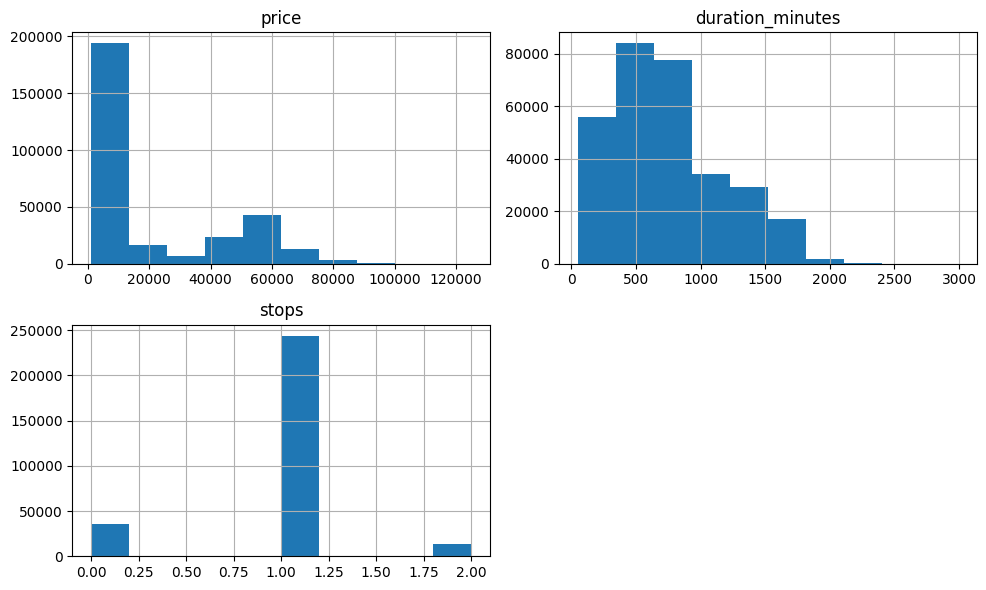

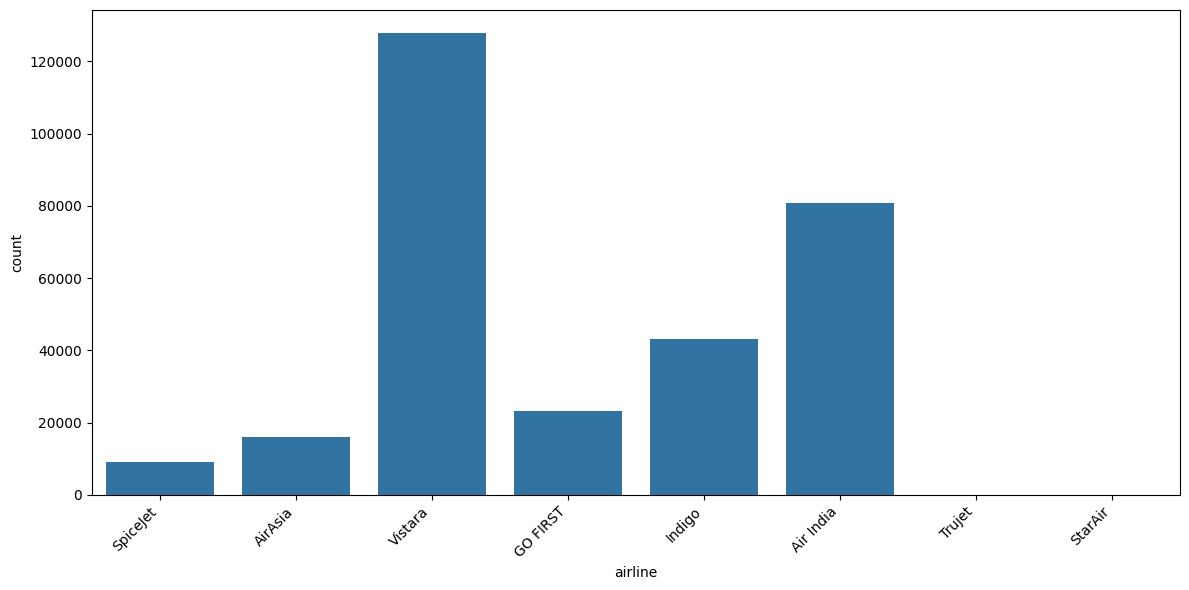

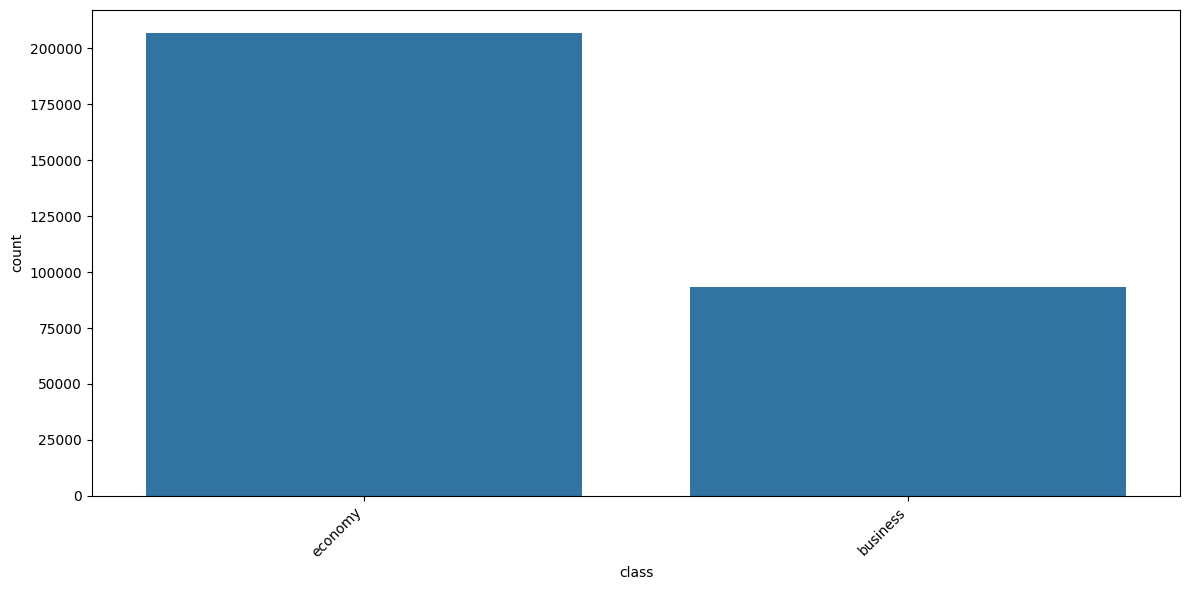

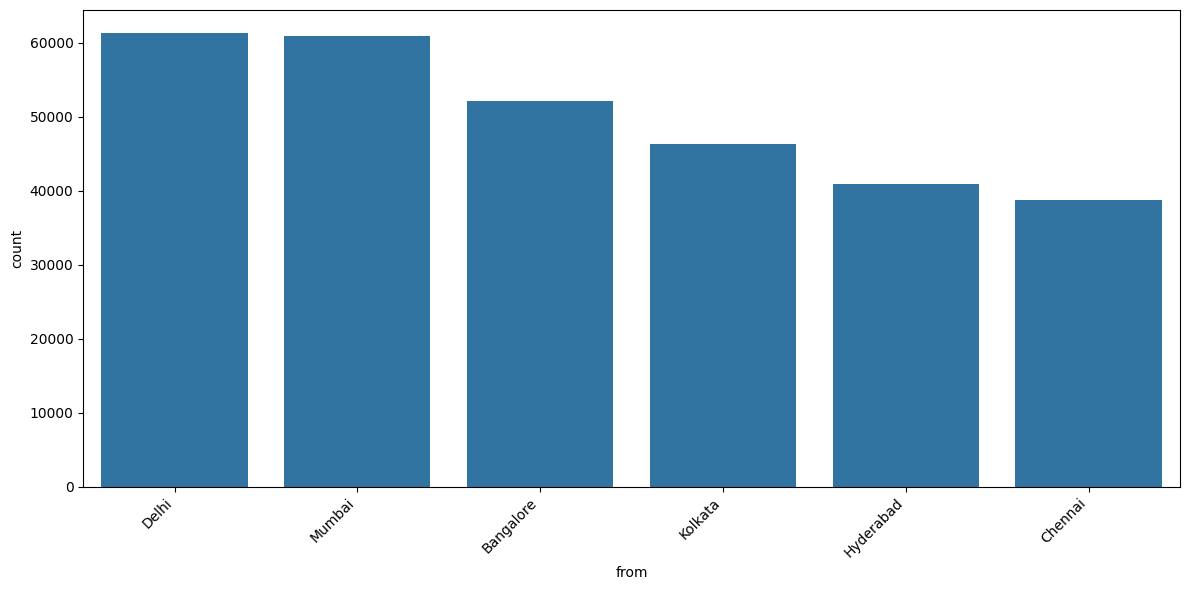

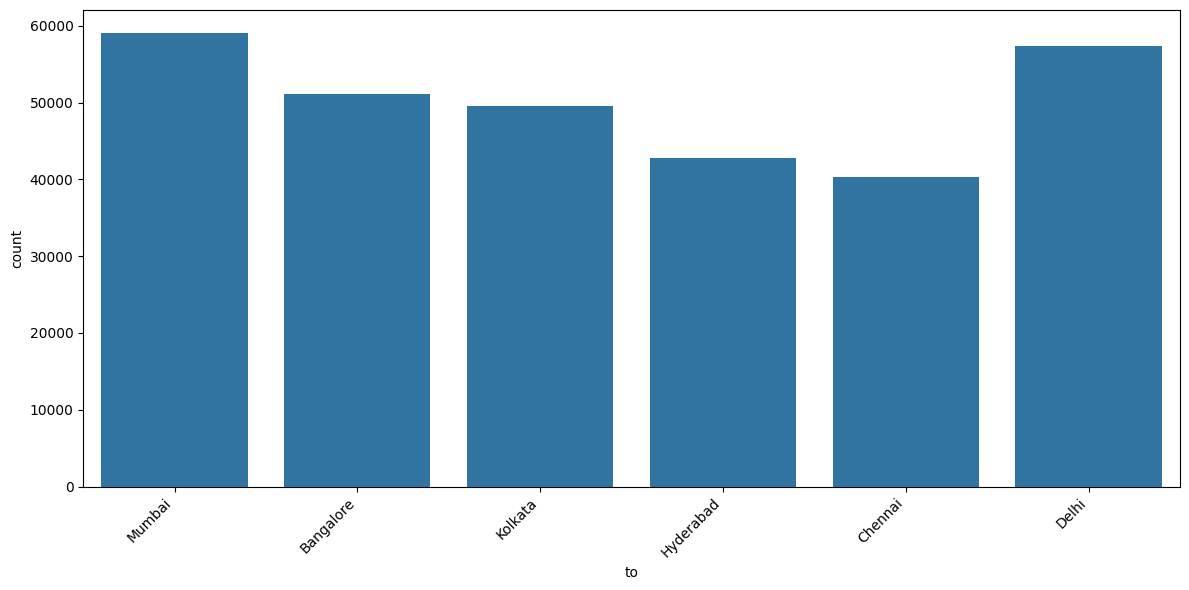

In [ ]:
# --- 3. Visualization Before Feature Engineering ---
# 3.1 Visualize numerical features using histograms
numerical_features_to_visualize = ['price', 'duration_minutes', 'stops']
train_data[numerical_features_to_visualize].hist(figsize=(10, 6))
plt.tight_layout()
plt.show()

# 3.2 Visualize categorical features using count plots
categorical_features_to_visualize = ['airline', 'class', 'from', 'to']
for feature in categorical_features_to_visualize:
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed
    sns.countplot(x=feature, data=train_data)
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.tight_layout()
    plt.show()


# Block 4 Feature Engineering and Model Building

This block engineers features and sets up the LSTM model:

* Defines lists for categorical and numerical features.
* Prepares the features (X) and target variables (y) for the model.
* Creates preprocessing pipelines using ColumnTransformer for scaling numerical features and one-hot encoding categorical features.
* Defines a function to create the LSTM model architecture.
* Splits the data into training and testing sets using train_test_split.
* Preprocesses the data using the defined pipelines.
* Reshapes the data to fit the LSTM input requirements (samples, timesteps, features).

In [ ]:
# --- 4. Feature Engineering and Model Building ---
# 4.1 Define feature lists
categorical_features = ['airline', 'class', 'from', 'to', 'stops']  # 'stops' added here
numerical_features = ['month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos']  # Updated with cyclic features

# 4.2 Prepare features (X) and target variables (y)
columns_to_drop = ['flight_num', 'dep_time', 'arr_time']
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
X = train_data.drop(columns=['price', 'duration_minutes'])
y = train_data[['price', 'duration_minutes']]

# 4.3 Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse=False to return dense array

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# 4.4 Create the LSTM model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(64, activation='relu'),
        Dense(2)  # Output for price and duration
    ])
    # Remove 'accuracy' from metrics and add more relevant metrics
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'accuracy'])
    return model

# 4.5 Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4.6 Preprocess the data using the pipeline
X_train_processed = preprocessor.fit_transform(X_train)  # Removed .toarray()
X_test_processed = preprocessor.transform(X_test)  # Removed .toarray()

# 4.7 Reshape data for LSTM input
X_train_reshaped = X_train_processed.reshape(X_train_processed.shape[0], 1, X_train_processed.shape[1])
X_test_reshaped = X_test_processed.reshape(X_test_processed.shape[0], 1, X_test_processed.shape[1])

#Block 5: Visualization after Feature Engineering

This block visualizes the data after feature engineering:

* Visualizes the transformed numerical features using histograms.
* Visualizes the one-hot encoded categorical features using a correlation matrix heatmap.

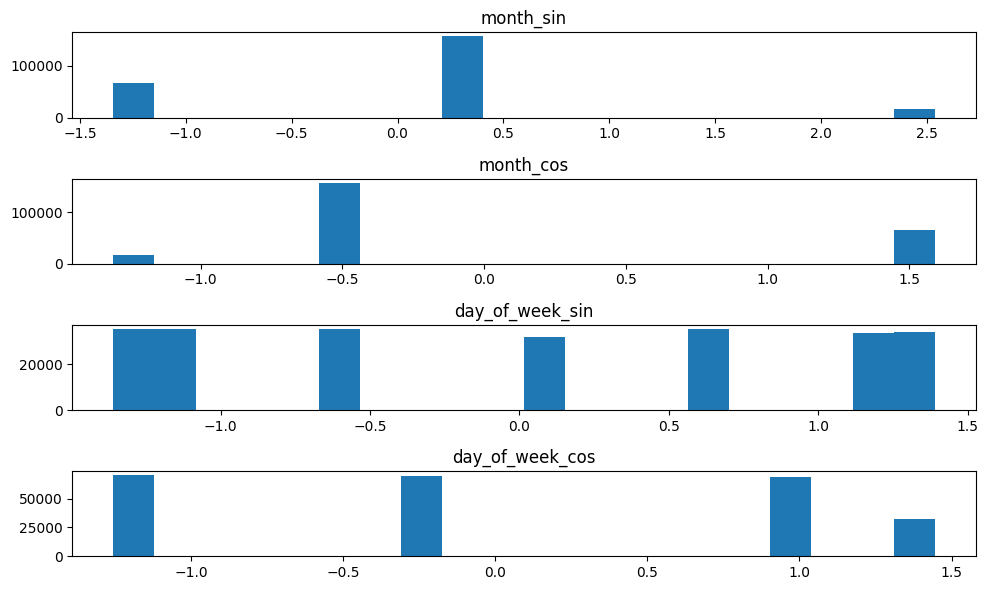

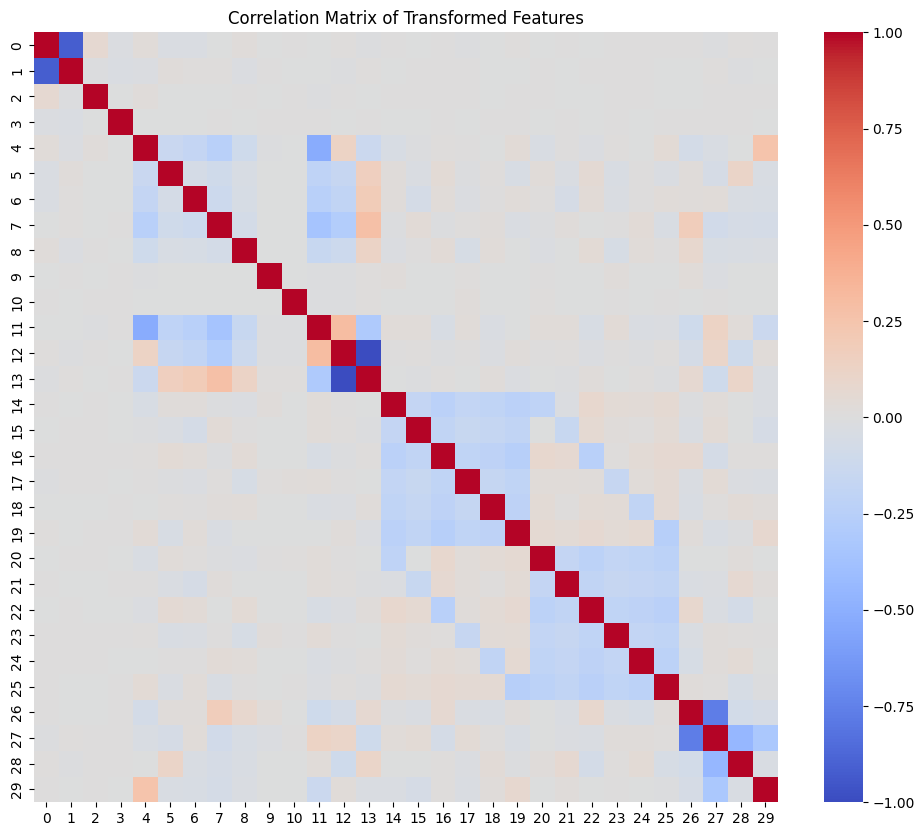

In [ ]:
# --- 5. Visualization after Feature Engineering ---
# 5.1 Visualize transformed numerical features
transformed_numerical_features = preprocessor.transformers_[0][2]  # Get numerical feature names
plt.figure(figsize=(10, 6))
for i, feature in enumerate(transformed_numerical_features):
    plt.subplot(len(transformed_numerical_features), 1, i + 1)
    plt.hist(X_train_processed[:, i], bins=20)
    plt.title(feature)
plt.tight_layout()
plt.show()

# 5.2 Visualize one-hot encoded categorical features using correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(pd.DataFrame(X_train_processed).corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix of Transformed Features')
plt.show()

#Block 6: Target Variable Scaling and Model Training

This block scales the target variables and trains the LSTM model:

* Scales the target variables ('price',
'duration_minutes') using MinMaxScaler.
* Builds and trains the LSTM model with the scaled target variables.
* Applies early stopping to prevent overfitting.

In [ ]:
# --- 6. Target Variable Scaling and Model Training ---
# 6.1 Add a scaler for target variables (price and duration_minutes)
from sklearn.preprocessing import MinMaxScaler  # Or StandardScaler

target_scaler = MinMaxScaler()  # Or StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)


# 6.2 Build and train the LSTM model with scaled target variables
n_timesteps = X_train_reshaped.shape[1]
n_features = X_train_reshaped.shape[2]
lstm_model = create_lstm_model((n_timesteps, n_features))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
epochs = 5

history = lstm_model.fit(
    X_train_reshaped, y_train_scaled,  # Use scaled target variables
    epochs=epochs,
    batch_size=32,
    validation_data=(X_test_reshaped, y_test_scaled),  # Use scaled target variables
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7507/7507 ━━━━━━━━━━━━━━━━━━━━ 71s 9ms/step - accuracy: 0.9012 - loss: 0.0082 - mae: 0.0587 - val_accuracy: 0.9156 - val_loss: 0.0066 - val_mae: 0.0520
Epoch 2/5
7507/7507 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9144 - loss: 0.0064 - mae: 0.0519 - val_accuracy: 0.9158 - val_loss: 0.0064 - val_mae: 0.0523
Epoch 3/5
7507/7507 ━━━━━━━━━━━━━━━━━━━━ 80s 8ms/step - accuracy: 0.9135 - loss: 0.0064 - mae: 0.0517 - val_accuracy: 0.9151 - val_loss: 0.0064 - val_mae: 0.0516
Epoch 4/5
7507/7507 ━━━━━━━━━━━━━━━━━━━━ 60s 8ms/step - accuracy: 0.9162 - loss: 0.0062 - mae: 0.0512 - val_accuracy: 0.9155 - val_loss: 0.0064 - val_mae: 0.0523
Epoch 5/5
7507/7507 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.9166 - loss: 0.0063 - mae: 0.0512 - val_accuracy: 0.9107 - val_loss: 0.0063 - val_mae: 0.0513


#Block 7: Model Evaluation

This block evaluates the trained LSTM model:

* Evaluates the model on the scaled test set using model.evaluate.
* Prints the Mean Squared Error (MSE) and Mean Absolute Error (MAE) to assess model performance.

In [ ]:
# --- 7. Model Evaluation ---
# Evaluate the model on the scaled test set
evaluation_results = lstm_model.evaluate(X_test_reshaped, y_test_scaled)
loss = evaluation_results[0]  # MSE
mae = evaluation_results[1]  # MAE

# Print evaluation results
print(f"LSTM Mean Squared Error on Test Set: {loss:.4f}")
print(f"LSTM Mean Absolute Error on Test Set: {mae:.4f}")

1877/1877 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9099 - loss: 0.0064 - mae: 0.0515
LSTM Mean Squared Error on Test Set: 0.0063
LSTM Mean Absolute Error on Test Set: 0.0513


#Block 8: Visualization after Model Training

This block visualizes the model's training history:

* Plots the training and validation loss over epochs.
* Plots the training and validation MAE over epochs.
* Plots the training and validation accuracy over epochs.

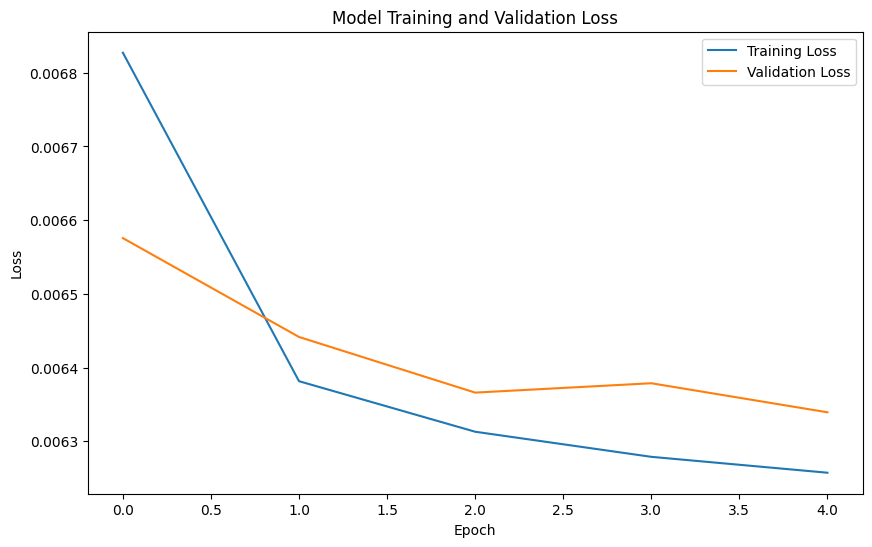

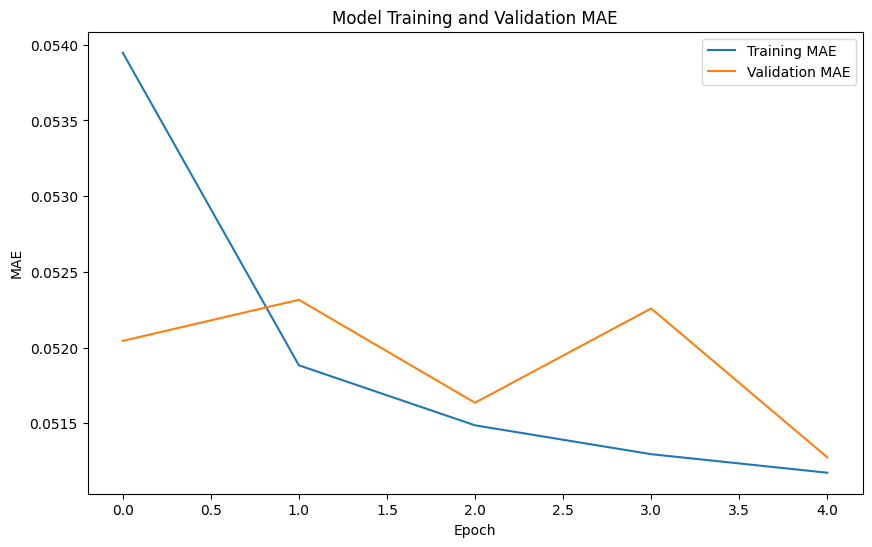

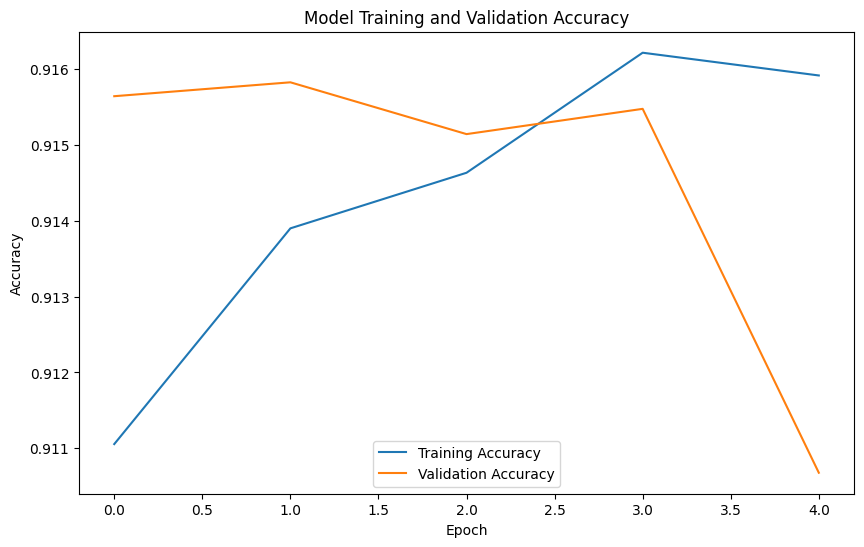

In [ ]:
# --- 8. Visualization after Model Training ---
# 8.1 Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Training and Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Block 9: Prediction Function

This block defines a function to make predictions using the trained LSTM model:

* Takes user input as a dictionary.
* Preprocesses the input data using the same pipeline used for training.
* Makes a prediction using the trained LSTM model.
* Inverse transforms the prediction to get the actual price and duration.
* Returns the predicted price and duration.


In [ ]:
# --- 9. Prediction Function ---
def predict_flight_price_duration(input_data):
    """Predicts flight price and duration based on user input."""
    # Preprocess the input data
    input_df = pd.DataFrame([input_data])  # Create a DataFrame from the input dictionary

    # --- Apply cyclic encoding to the input data ---
    input_df = cyclic_encode(input_df, 'month', 12)
    input_df = cyclic_encode(input_df, 'day_of_week', 7)

    input_processed = preprocessor.transform(input_df) # Remove .toarray() as it's already a dense array
    input_reshaped = input_processed.reshape(input_processed.shape[0], 1, input_processed.shape[1])

    # Make the prediction
    prediction_scaled = lstm_model.predict(input_reshaped)

    # Inverse transform to get actual price and duration
    prediction = target_scaler.inverse_transform(prediction_scaled)
    price = prediction[0, 0]
    duration_minutes = prediction[0, 1]

    return price, duration_minutes

# Block 10: Example to test the model using prediction function

This block demonstrates how to use the prediction function:

* Defines an example user input dictionary.
* Calls the predict_flight_price_duration function with the user input.
* Prints the predicted price and duration.

In [ ]:
# --- 10. Example to test the model using prediction function ---
# Example usage with cyclic encoding:
user_input = {
    'airline': 'IndiGo',
    'class': 'Economy',
    'from': 'Delhi',
    'to': 'Mumbai',
    'stops': 0,
    'month': 7,  # July
    'day_of_week': 0  # Monday (0: Monday, 1: Tuesday, etc.)
}

predicted_price, predicted_duration = predict_flight_price_duration(user_input)

print(f"Predicted Price: {abs(predicted_price):.2f}")
print(f"Predicted Duration (minutes): {abs(predicted_duration):.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted Price: 12275.13
Predicted Duration (minutes): 131.99


#Potential Improvements for the Airfare Predictor

1. **Feature Engineering:**

* *More Relevant Features:* Consider  adding  more relevant features that could influence airfare, such as:

   =>  Demand-based features: Include data on historical booking trends, flight search volume, or competitor pricing for similar routes.

   =>  Economic indicators: Incorporate factors like fuel prices, currency exchange rates, or inflation, which can affect airline costs and pricing strategies.

   =>  Special events: Account for holidays, festivals, or major events at the destination, which often drive up demand and prices.

   =>  Time of day: Include the departure and arrival times as these can impact pricing.
  
* *Feature Interactions:* Explore interactions between existing features. For instance, the impact of the airline might vary depending on the class or route.
2. **Model Selection and Hyperparameter Tuning:**

* *Experiment with other models:* Try using different types of models, such as tree-based models (Random Forest, XGBoost), or other neural network architectures.

* *Hyperparameter Optimization:* Fine-tune the hyperparameters of your LSTM model (e.g., number of layers, units, learning rate) using techniques like grid search or Bayesian optimization.

3. **Data Quality and Quantity:**
* *More Data:* A larger dataset could lead to better model performance. If possible, try to acquire more flight data from other sources.
* *Data Cleaning:* Pay close attention to data quality and handle outliers or inconsistencies effectively.
* *Data Augmentation:* Techniques like SMOTE (Synthetic Minority Over-sampling Technique) could be used to address class imbalance if present.

4. **External Data:**
* *Weather data:* Incorporate weather conditions at the departure and arrival airports, as they can affect flight schedules and pricing.
* *Airport information:* Include data on airport congestion or delays, which might indirectly influence pricing.


#Conclusion

This project demonstrates the potential of machine learning for airfare prediction. Though further refinement is needed, leveraging LSTM networks and insightful features can empower travelers and the travel industry with valuable pricing insights. The future of airfare prediction is bright, promising greater accuracy and accessibility for all.